### DOWNLOAD MODULES

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

### loading data and drop unesesary then one hot encode

In [6]:
data = pd.read_csv("Customer-Churn-Records.csv")
# Step 1: Drop unnecessary columns
df = data.drop(columns=["RowNumber", "CustomerId", "Surname"])
# Step 2: One-hot encode categorical features
df = pd.get_dummies(df, drop_first=True)

### EDA

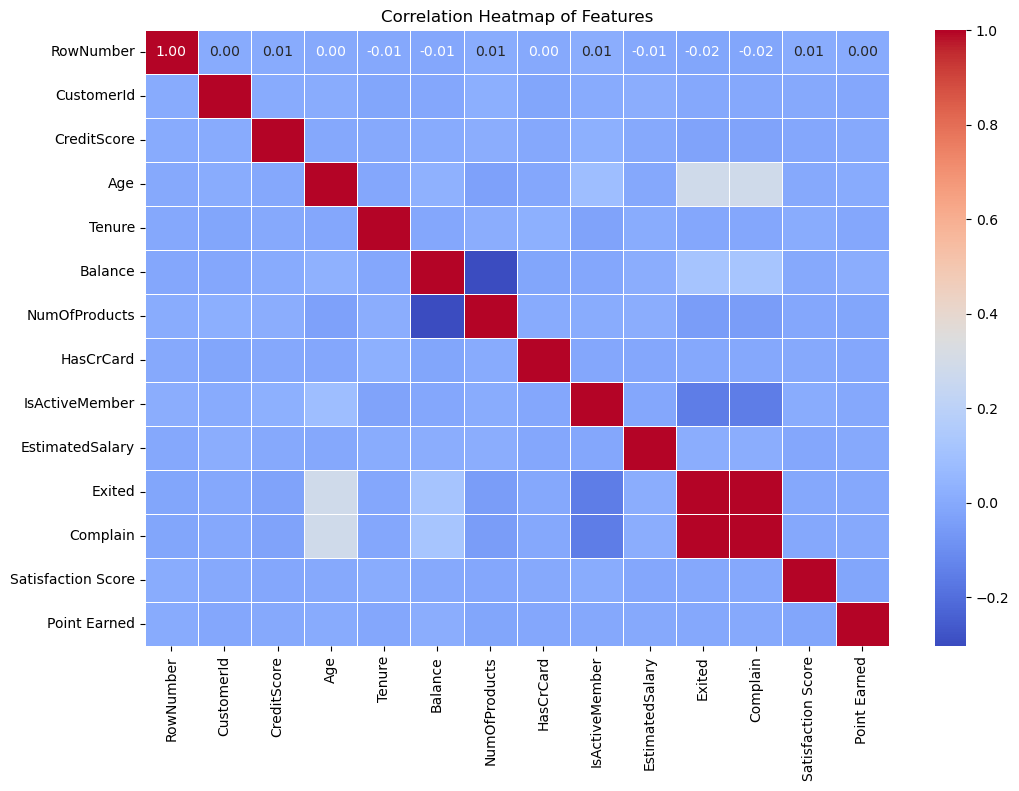

In [27]:
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

C:\Users\salma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\salma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


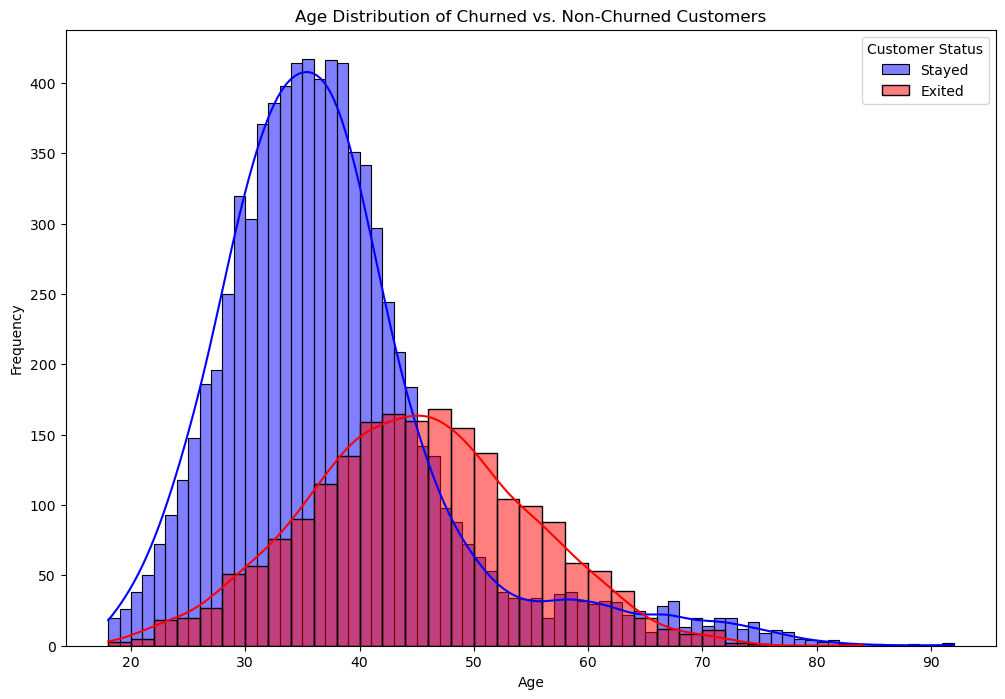

In [23]:
plt.figure(figsize=(12, 8))
sns.histplot(data[data['Exited'] == 0]['Age'], kde=True, color='blue', label='Stayed')
sns.histplot(data[data['Exited'] == 1]['Age'], kde=True, color='red', label='Exited')
plt.legend(title='Customer Status')
plt.title('Age Distribution of Churned vs. Non-Churned Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

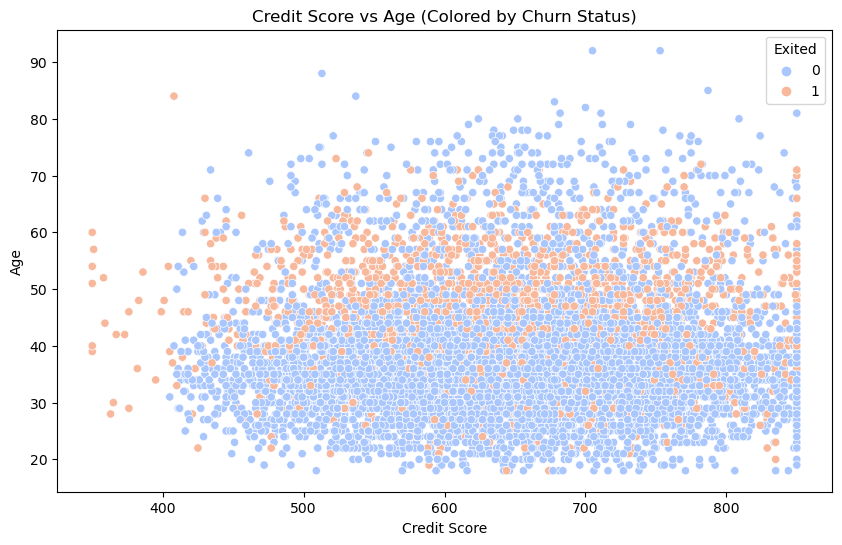

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CreditScore', y='Age', hue='Exited', data=data, palette='coolwarm')
plt.title('Credit Score vs Age (Colored by Churn Status)')
plt.xlabel('Credit Score')
plt.ylabel('Age')
plt.show()

### SMOTE FOR BALENCING DATA

In [7]:
# Step 3: Split features and target
X = df.drop("Exited", axis=1)
y = df["Exited"]
# Step 4: Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

### TRAIN TEST SPLIT THEN SCALING NUMERICAL INPUTS

In [10]:
# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 6: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train a Random Forest classifier with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}

### GRID SEARCH FOR BEST HP

In [11]:
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rfc, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

### SAVE MODEL AND SCALERS

In [13]:
# Step 8: Save model and scaler
joblib.dump(best_model, 'churn_model_rf.joblib')
joblib.dump(scaler, 'churn_scaler.joblib')
joblib.dump(X.columns.tolist(), 'churn_columns.joblib')

['churn_columns.joblib']

### EVALUATION MODEL

In [14]:
# Step 9: Evaluate the model
y_pred = best_model.predict(X_test_scaled)
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]

report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)
conf_matrix = confusion_matrix(y_test, y_pred)

In [17]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2463
           1       1.00      1.00      1.00      2315

    accuracy                           1.00      4778
   macro avg       1.00      1.00      1.00      4778
weighted avg       1.00      1.00      1.00      4778



In [18]:
print(roc_auc)
print(conf_matrix)

0.9997441179127108
[[2460    3]
 [   5 2310]]


<Axes: xlabel='Importance', ylabel='columns'>

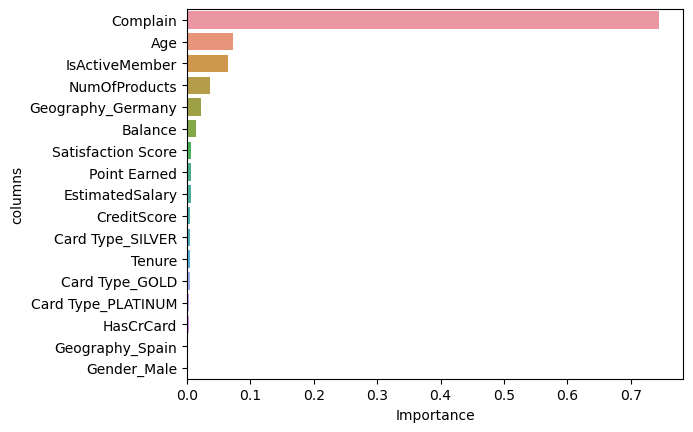

In [35]:
feature_names = X.columns
importances = best_model.feature_importances_
df = pd.DataFrame({
    'columns': feature_names,
    'Importance': importances
})
df = df.sort_values(by="Importance", ascending=False)
sns.barplot(df,x='Importance',y="columns")

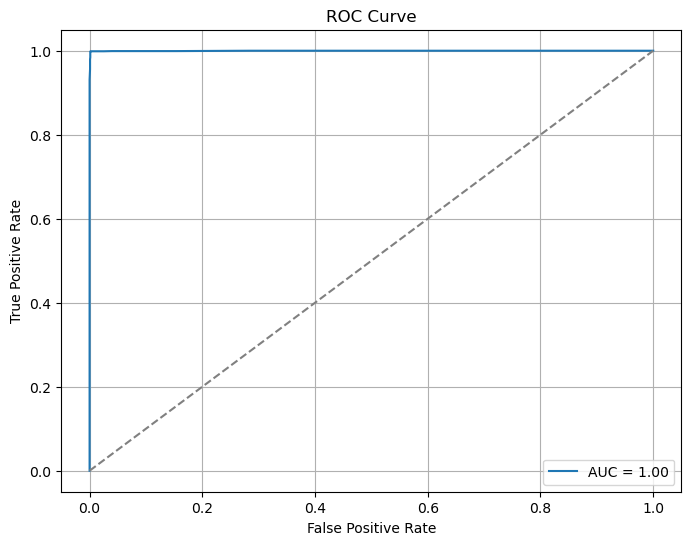

In [36]:
# Step 10: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()